<a href="https://colab.research.google.com/github/mot1122/CNN_model/blob/main/use_pytorch/MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install pytorch-lightning==0.7.1

In [45]:
import torch,torchvision

In [46]:
torch.__version__, torchvision.__version__

('1.10.0+cu111', '0.11.1+cu111')

# 特徴抽出練習

In [47]:
from torchvision import transforms

In [48]:
transform=transforms.Compose([
  transforms.ToTensor()
])

In [49]:
train=torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=transform
)

In [50]:
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [51]:
train[0][0].shape

torch.Size([1, 28, 28])

In [52]:
import matplotlib.pyplot as plt

In [53]:
img=train[0][0]

In [54]:
img=img.reshape(img.shape[1],img.shape[2])

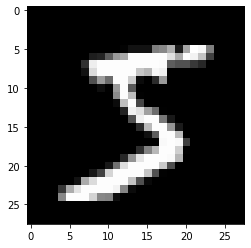

In [55]:
plt.imshow(img,cmap="gray")

In [56]:
import torch.nn as nn
import torch.nn.functional as F

In [57]:
conv=nn.Conv2d(
    in_channels=1,
    out_channels=4,
    kernel_size=3,
    stride=1,
    padding=1
)

In [58]:
conv.weight

Parameter containing:
tensor([[[[-0.2831,  0.1678,  0.1596],
          [-0.0967,  0.2492,  0.3126],
          [ 0.1775, -0.1357,  0.2853]]],


        [[[ 0.3083, -0.2464, -0.0736],
          [ 0.0297,  0.1136, -0.3106],
          [-0.1705,  0.2562, -0.1937]]],


        [[[-0.1171, -0.0669, -0.2893],
          [ 0.1934, -0.0677, -0.3229],
          [-0.0053,  0.0175,  0.2232]]],


        [[[-0.0514, -0.0973, -0.1408],
          [ 0.2661,  0.0365, -0.0823],
          [-0.2675, -0.1081, -0.3322]]]], requires_grad=True)

In [59]:
conv.weight.shape

torch.Size([4, 1, 3, 3])

In [60]:
conv.bias

Parameter containing:
tensor([ 0.2352,  0.3310,  0.0705, -0.1281], requires_grad=True)

In [61]:
x=train[0][0]
x=x.reshape(1,1,28,28)
x=conv(x)
x.shape

torch.Size([1, 4, 28, 28])

In [62]:
x=F.max_pool2d(x,kernel_size=2,stride=2)
x.shape

torch.Size([1, 4, 14, 14])

In [63]:
x=x.view(-1,x.shape[1]*x.shape[2]*x.shape[3])

In [64]:
x.shape

torch.Size([1, 784])

In [65]:
fc=nn.Linear(x.shape[1],10)
x=fc(x)
x

tensor([[-3.1420e-02, -1.4761e-01,  3.5799e-01, -2.2803e-02,  3.0551e-04,
         -1.0632e-02,  1.6929e-01, -2.6702e-01, -2.8754e-03,  3.3269e-02]],
       grad_fn=<AddmmBackward0>)

# データセット

In [66]:
train_val=torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=transform
)
test=torchvision.datasets.MNIST(
    root=".",
    train=False,
    download=True,
    transform=transform
)

In [67]:
n_train=int(len(train_val)*0.8)
n_val=len(train_val)-n_train

In [68]:
n_train,n_val

(48000, 12000)

In [69]:
torch.manual_seed(0)
train,val=torch.utils.data.random_split(train_val,[n_train,n_val])

In [70]:
len(train),len(val),len(test)

(48000, 12000, 10000)

# NNモデル

In [71]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer

In [72]:
pl.__version__

'0.7.1'

In [73]:
class TrainNet(pl.LightningModule):
  def train_dataloader(self):
    return torch.utils.data.DataLoader(train,self.batch_size,shuffle=True)
  def training_step(self,batch,batch_nb):
    X,y=batch
    output=self.forward(X)
    loss=self.lossfun(output,y)
    results={"loss":loss}
    return results

In [74]:
class ValidationNet(pl.LightningModule):
  def val_dataloader(self):
    return torch.utils.data.DataLoader(val,self.batch_size)
  def validation_step(self,batch,batch_nb):
    X,y=batch
    output=self.forward(X)
    loss=self.lossfun(output,y)
    pred=torch.argmax(output,dim=1)
    acc=torch.sum(y==pred)*1.0/len(y)
    results={"val_loss":loss,"val_acc":acc}
    return results
  def validation_end(self,outputs):
    avg_loss=torch.stack([x["val_loss"] for x in outputs]).mean()
    avg_acc=torch.stack([x["val_acc"] for x in outputs]).mean()
    results={"val_loss":avg_loss,"val_acc":avg_acc}
    return results

In [75]:
class TestNet(pl.LightningModule):
  def test_dataloader(self):
    return torch.utils.data.DataLoader(test,self.batch_size)
  def test_step(self,batch,batch_nb):
    X,y=batch
    output=self.forward(X)
    loss=self.lossfun(output,y)
    pred=torch.argmax(output,dim=1)
    acc=torch.sum(y==pred)*1.0/len(y)
    results={"test_loss":loss,"test_acc":acc}
    return results
  def test_end(self,outputs):
    avg_loss=torch.stack([x["test_loss"] for x in outputs]).mean()
    avg_acc=torch.stack([x["test_acc"] for x in outputs]).mean()
    results={"test_loss":avg_loss,"test_acc":avg_acc}
    return results

In [76]:
class Net(TrainNet,ValidationNet,TestNet):
  def __init__(self,input_size=784,hidden_size=100,output_size=10,batch_size=256):
    super(Net,self).__init__()
    self.batch_size=batch_size
    self.conv=nn.Conv2d(in_channels=1,out_channels=4,kernel_size=3,stride=1,padding=1)
    self.fc1=nn.Linear(input_size,hidden_size)
    self.fc2=nn.Linear(hidden_size,output_size)
  def lossfun(self,y,pred):
    return F.cross_entropy(y,pred)
  def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(),lr=0.01)
  def forward(self,x):
    x=self.conv(x)
    x=F.max_pool2d(x,2,2)
    x=x.view(x.size(0),-1)
    x=F.relu(self.fc1(x))
    x=self.fc2(x)
    return x

In [77]:
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benckmark=False

In [78]:
torch.manual_seed(0)
net=Net()
trainer=Trainer(gpus=1,max_epochs=30)
trainer.fit(net)

Validation sanity check:   0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/47 [00:00<?, ?it/s]

1

In [79]:
trainer.test()
trainer.callback_metrics

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------


{'epoch': 29,
 'loss': 0.12737050652503967,
 'test_acc': 0.953808605670929,
 'test_loss': 0.16072967648506165,
 'val_acc': 0.9493018388748169,
 'val_loss': 0.1761496216058731}

In [80]:
torch.save(net.state_dict(),"mnist.pt")

# 予測

In [81]:
net=Net()
net.load_state_dict(torch.load("mnist.pt"))

<All keys matched successfully>

In [82]:
train[0][0].shape

torch.Size([1, 28, 28])

In [83]:
sample=train[0][0].unsqueeze(0)
sample.shape

torch.Size([1, 1, 28, 28])

In [84]:
output=net.forward(sample)
output

tensor([[-5.3323, -4.3800, -2.7038,  2.4536,  2.5788,  3.0097, -4.8920,  3.8730,
          2.1647,  7.8220]], grad_fn=<AddmmBackward0>)

In [85]:
pred=output.argmax()

In [86]:
type(train)

torch.utils.data.dataset.Subset

In [87]:
train[0][1]

9